In [4]:
from ott.solvers import linear
from ott.geometry import pointcloud
from ott import utils
import jax.numpy as jnp
import jax
from jaxtyping import Array, Float, Int
from ott.solvers.linear.implicit_differentiation import ImplicitDiff
import matplotlib.pyplot as plt
import optax
import functools
from tqdm import tqdm

<BarContainer object of 201 artists>

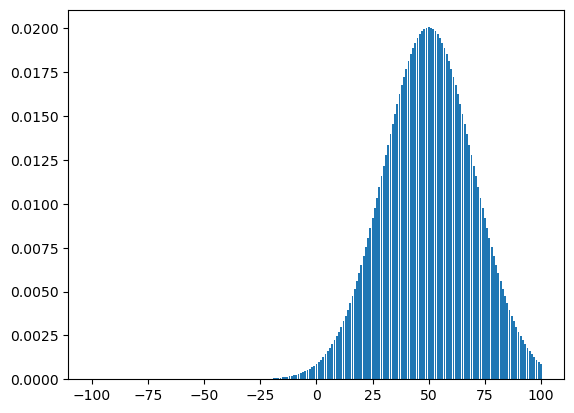

In [7]:
# initialize a gaussian kernel, mu_true, on domain X
size = 100
sigma = 20
X = jnp.arange(-size, size + 1, 1).astype(float)
grid = X.reshape((X.shape[0], 1)).astype(float)
mu_true = jnp.exp(-((X-50)**2) / (2 * sigma**2)) # gaussian kernel (sigma = 1, center = 0)
mu_true /= jnp.sum(mu_true)
plt.bar(X, mu_true)

In [6]:
solve_fn = jax.jit(linear.solve, static_argnames=['max_iterations', 'progress_fn'])
progress_fn = utils.default_progress_fn()
implicit_diff = ImplicitDiff(solver_kwargs={'max_steps': 5000})

"""
Compute regularized ot cost for transporting between marginals mu and mu_true on geometry x
"""
def ot_marginal_loss(mu: Float[Array, "n "], mu_true: Float[Array, "n "], x: Float[Array, "n d"], epsilon: Float):
    geom = pointcloud.PointCloud(x, x, epsilon=epsilon)
    ot = solve_fn(geom, implicit_diff=ImplicitDiff(), a=mu, b=mu_true, max_iterations=5000)
    return ot.reg_ot_cost

"""
Compute W2 distance between marginals mu and mu_true on geometry x
"""
def ot_marginal_loss_w2(mu: Float[Array, "n "], mu_true: Float[Array, "n "], x: Float[Array, "n d"], epsilon: Float):
    geom = pointcloud.PointCloud(x, x, epsilon=epsilon)
    ot = solve_fn(geom, implicit_diff=ImplicitDiff(), a=mu, b=mu_true, max_iterations=5000)
    return jnp.dot(ot.geom.cost_matrix.ravel(), ot.matrix.ravel())

"""
ot primal cost for transporting between marginals mu and mu_true on geometry x
"""
def ot_marginal_loss_primal(mu: Float[Array, "n "], mu_true: Float[Array, "n "], x: Float[Array, "n d"], epsilon: Float):
    geom = pointcloud.PointCloud(x, x, epsilon=epsilon)
    ot = solve_fn(geom, implicit_diff=ImplicitDiff(), a=mu, b=mu_true, max_iterations=5000)
    return ot.primal_cost

"""
1-d gaussian kernel with center c, standard deviation sigma, domain
"""
def gaussian_kernel(c, sigma, X):
    mu = jnp.exp(-((X-c)**2)/(2 * sigma**2))
    mu /= jnp.sum(mu)
    return mu

"""
loss function for logits of a probability distribution
"""
def logit_loss(theta: Float[Array, "n"], mu_true: Float[Array, "n "], X: Float[Array, "n 1 "] = X):
    mu = jax.nn.softmax(theta)
    return ot_marginal_loss(mu, mu_true, X, None)

In [139]:
def compute_q(mu, grid, sigma2):
    """Compute the discrete Gaussian distribution over the grid."""
    logits = -(grid - mu)**2 / (2 * sigma2)
    return jax.nn.softmax(logits)

def learn_mu(grid, p, sigma2, initial_mu=0.0, learning_rate=0.1, steps=5000):
    """Learn the optimal mu using gradient descent."""
    
    # initialize solver
    solver = optax.adam(learning_rate=0.1)
    mu = jnp.array(initial_mu)
    opt_state = solver.init(mu)

    grid_reshaped = grid.reshape((grid.shape[0], 1)).astype(float)
#     def loss_fn_l2(mu):
#         q = compute_q(mu, grid, sigma2)
#         return jnp.sum(jnp.abs(q - p)**2)
    
    def loss_fn_ot(mu):
        q = compute_q(mu, grid, sigma2)
        return ot_marginal_loss(q, p, grid_reshaped, None)
    grad_fn = jax.value_and_grad(loss_fn_ot)
    
#     print(loss_fn_ot(50.0))
#     print(loss_fn_ot(0.0))
#     print(grad_fn(50.0))
#     print(grad_fn(0.0))
    
    #plot the gradients
    _, grads = jax.vmap(grad_fn)(jnp.linspace(-100, 100, 200))
#     plt.plot(jnp.linspace(0, 100, 100), grads, marker='o')
    
    @jax.jit
    def update(mu, opt_state):
        loss_val, grad = grad_fn(mu)
        updates, opt_state = solver.update(grad, opt_state)
        mu = optax.apply_updates(mu, updates)
        return loss_val, mu, opt_state, grad
    
    for step in tqdm(range(1, steps + 1), desc="Training Steps", unit="step"):
        loss_val, mu, opt_state, mu_grad = update(mu, opt_state)
    
    return mu, grads

## Learn mean of gaussian distribution, and plot gradient of loss function

Training Steps: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:44<00:00, 113.63step/s]


learned mu: 50.25446701049805


<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

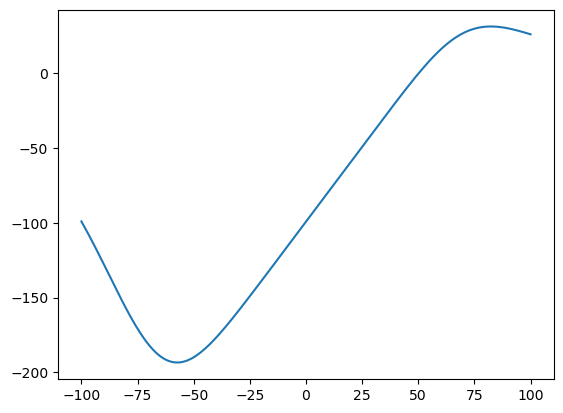

In [140]:
mu, grads = learn_mu(X, mu_true, 400.0, )
print(f"learned mu: {mu}")

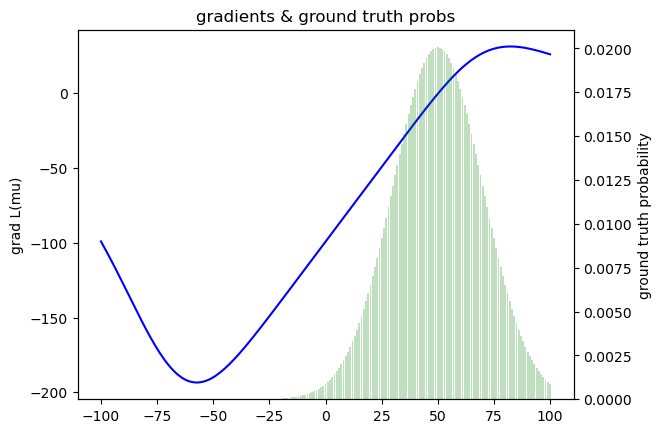

In [152]:
fig, ax1 = plt.subplots()
# Plot on the first y-axis
ax1.plot(jnp.linspace(-100, 100, 200), grads, 'b-')  
ax1.set_ylabel('grad L(mu)')

# Create second y-axis (shares the same x-axis)
ax2 = ax1.twinx()
ax2.bar(X, mu_true, color='g', alpha=0.25)
ax2.set_ylabel('ground truth probability')

# Show plot
plt.title("gradients & ground truth probs")
plt.show()